# Построение предсказания на основе агрегирации ответов моделей - взвешенное предсказание

In [1]:
import os
import re
import pickle
import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from hack_lap.utils.evaluate import precision_recall, estimate_prediction

In [2]:
import matplotlib
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def calculate_metrics_one_vs_rest(yt, yp, cls_count_0=5000, cls_count_1=200, eps=1e-6):
    yt, yp = estimate_prediction(yt, yp, cls_count_0, cls_count_1)
    tp = (yp * yt).sum()
    tn = ((1 - yp) * (1 - yt)).sum()
    fp = (yp * (1 - yt)).sum()
    fn = ((1 - yp) * yt).sum()

    recall_1 = tp / (tp + fn)
    recall_0 = tn / (tn + fp)
    precision_1 = recall_1 * cls_count_1 / (recall_1 * cls_count_1 + (1.0 - recall_0) * cls_count_0)
    precision_0 = recall_0 * cls_count_0 / (recall_0 * cls_count_0 + (1.0 - recall_1) * cls_count_1)
    f1_1 = 2 * recall_1 * precision_1 / (recall_1 + precision_1 + eps)
    f1_0 = 2 * recall_0 * precision_0 / (recall_0 + precision_0 + eps)
    return recall_1, precision_1, f1_1


In [4]:
DIR_DATA = os.path.join('..', 'data')
DIR_PREDICT = os.path.join(DIR_DATA, 'predict') 
DIR_MODEL = os.path.join(DIR_DATA, 'model')
files = [n for n in os.listdir(DIR_MODEL) if n.endswith('.pkl') and 'Nepoch' in n]

files = [n for n in files if 'Patt' in n]

ps = re.compile(f'seed-(\d+)', re.I)
seeds = sorted([int(g.group(1)) for f in files for g in ps.finditer(f)])
len(files)

4

In [5]:
predict = []
weights = []
for f in tqdm(files):
    with open(os.path.join(DIR_MODEL, f), 'rb') as fp:
        data = pickle.load(fp)
    yt_dev, yp_dev, yp_test = data['yt_dev'], data['yp_dev'], data['yp_test']

    yp_dev = np.mean(yp_dev, axis=1).ravel()
    rp0, rp1, th = precision_recall(yt_dev, yp_dev)
    f1 = 2 * rp1[0] * rp1[1] / (rp1[0] + rp1[1] + 1e-6)
    ii = np.argmax(f1)
    f1 = f1[ii]
    th = th[ii]

    yp_test = np.mean(yp_test, axis=1)
    yp_test = (yp_test > th).astype(int).reshape(-1, 1)
    predict.append(yp_test)
    
    re, pr, f1 = calculate_metrics_one_vs_rest(yt_dev, yp_dev)
    weights.append(f1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
submission = np.concatenate(predict, axis=1).astype(np.float64)
w = np.array(weights).reshape(1, -1)
submission *= w
print(submission.shape)

submission = np.sum(submission, axis=1) / np.sum(w)
th = 0.5
cls_pred = (submission > th).astype(int)
print(f'# active: {np.sum(cls_pred)}')

(1614, 4)
# active: 30


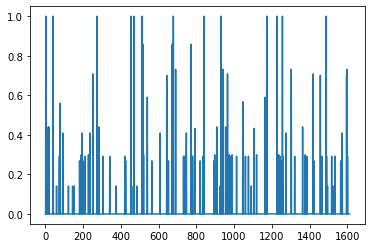

In [7]:
plt.plot(submission);

In [8]:
df = pd.read_csv(os.path.join(DIR_DATA, 'test.csv'))
df['Active'] = cls_pred

seed_hash = hash(''.join(map(str, seeds)))
name = f'mdl-L4-H32-Patt-NF-BF-#seeds-{len(seeds)}_hash-{seed_hash}_mean_f1_weighted_th-{th}'

df.to_csv(os.path.join(DIR_PREDICT, name + '.csv'), index=False)

with open(os.path.join(DIR_PREDICT, name + '.json'), 'w') as fp:
    json.dump({'seeds': seeds}, fp, indent=2)